In [136]:
%matplotlib inline
import pylab
import numpy as np
import nengo
import matplotlib.pyplot as plt
#import cPickle as pickle


In [137]:
time_per_val = 0.5
time_per_val_testing = 0.5
train_int = 45
train_time = train_int*time_per_val_testing
childhood = 200
training1 = childhood+train_time
glasses_on = training1+200
training2 = glasses_on+train_time
mod = 23*(np.pi/180) #degrees to rad

In [138]:
def training_fn(t):
    if (t<= childhood) or (training1 <= t < glasses_on):
        return 1
    else:
        return 0

def glasses_fn(t):
    if t >= training1:
        return 1
    else:
        return 0


dist = nengo.dists.Uniform(-np.pi/2, np.pi/2) 
vals_testing = np.linspace(-np.pi/2,np.pi/2, train_int)
training_time1 = childhood
training_time2 = glasses_on-training1
vals_training1 = dist.sample((training_time1/time_per_val)+1)
vals_training2 = dist.sample((training_time2/time_per_val)+1)
    
    
def stim_fn(t, x):
    glasses, train = x
    if glasses < 0.5 and train >= 0.5:
        # First training period, random things appear
        index = int((t - 0)/time_per_val)
        return vals_training1[index% len(vals_training1)]
    if glasses < 0.5 and train < 0.5: 
        # Test the owl by forcing it to incrimentally look at all the things
        # Gives data to form pre-learning tuning curve
        index = int((t - childhood)/time_per_val_testing)
        return vals_testing[index% len(vals_testing)]
    if glasses >= 0.5 and train >= 0.5:
        # Second Training period, random things appear
        index = int((t - training1)/time_per_val)
        return vals_training2[index % len(vals_training2)]
    if glasses >=0.5 and train < 0.5:
        # Last period, test owl by forcing it to incrimentally look at things
        index = int((t-glasses_on)/time_per_val_testing)
        return vals_testing[index % len(vals_testing)]
        
def convert_to_circle(x):
    #takes a value in RADIANS, converts ton x y cartesian coordinates
    # x is gonna be an angle value, we're assuming r=1 for the sake of simplicity
    return np.cos(x), np.sin(x)
    
def is_mod_fn(t, x):
    stim, glasses = x
    if glasses >= 0.5:
        return stim+mod
    else:
        return stim

def error_on(training):
    if training >= 0.5:
        return 1
    else:    
        return 0
        
model = nengo.Network()
with model:
    training = nengo.Node(training_fn)
    glasses = nengo.Node(glasses_fn)
    stim = nengo.Node(stim_fn, size_in = 2, size_out = 1)
    use_mod = nengo.Node(is_mod_fn, size_in = 2, size_out = 1) 
    
    train2stim = nengo.Connection(training, stim[1], synapse = None)
    glasses2stim = nengo.Connection(glasses, stim[0], synapse = None)
    
    # Connecting a bunch of different ensembles
    visual_raw = nengo.Ensemble(n_neurons=300, dimensions=3, intercepts = nengo.dists.Uniform(0.81,0.91))
    auditory = nengo.Ensemble(n_neurons=200, dimensions = 2, intercepts = nengo.dists.Uniform(0.81,0.91))
    stim2use_mod = nengo.Connection(stim, use_mod[0], synapse = None)
    glasses2use_mod = nengo.Connection(glasses, use_mod[1], synapse = None)
    use_mod2vis = nengo.Connection(use_mod, visual_raw[:2], function = convert_to_circle)
    stim2aud = nengo.Connection(stim, auditory, function = convert_to_circle)
    
    # Error stuff
    
    error = nengo.Ensemble(n_neurons = 400, dimensions = 2) #error_fn, size_in = 4, size_out = 2)
    visual_cor = nengo.Ensemble(n_neurons = 200, dimensions = 2, intercepts = nengo.dists.Uniform(0.81,0.91))
    vis2vis = nengo.Connection(visual_raw[:2], visual_cor[:2],synapse = None, learning_rule_type = nengo.PES(learning_rate= 3e-4))
    #vis2vis.learning_rule_type = nengo.PES()
    #nengo.Connection(error, vis2vis.learning_rule)
    vis2vis.solver = nengo.solvers.LstsqL2(weights = False)
    aud2error = nengo.Connection(auditory[:2], error[:2],transform = -1)
    vis2error = nengo.Connection(visual_cor[:2], error[:2])
    
    nengo.Connection(error, vis2vis.learning_rule)
    
    probe = nengo.Probe(visual_cor.neurons)
    probe2 = nengo.Probe(visual_raw.neurons)
    probe_usemod = nengo.Probe(use_mod)
    probe_stim = nengo.Probe(stim)

In [139]:
sim = nengo.Simulator(model)
sim.run(training2)

Simulation finished in 0:05:39.                                                 


In [167]:
print(sim.trange()[-1])
print(training2)
#x = vals_testing

#print((180/np.pi)*(x[i]-x[i+1]))
y = sim.data[probe]#[-int():]
#pickle.dump(sim.data[probe], open(owldata, 'wb'))
print(y.shape)
print(len(y))
#z = sim.trange()
#plt.plot(z,y)
mod_data = sim.data[probe_usemod]
stim_data = sim.data[probe_stim]

vis2_data = sim.data[probe2]

480.438
445.0
(480437, 200)
480437


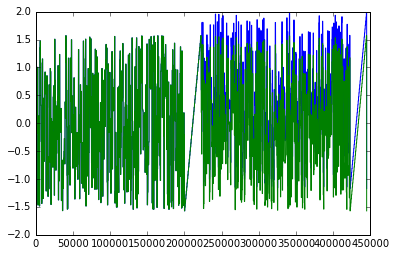

In [141]:
#pylab.plot(mod_data[int(childhood/dt):int(training1/dt)])
#pylab.plot(stim_data[int(childhood/dt):int(training1/dt)])
dt = 0.001
#pylab.plot(mod_data[int(glasses_on/dt):int(training2/dt)], c = 'r')
#pylab.plot(stim_data[int(glasses_on/dt):int(training2/dt)])
pylab.plot(mod_data)
pylab.plot(stim_data)


In [142]:
def sim_gen(time, cnt):
    cur = 0
    yield np.mean(sim.data[probe][-int(time_per_val_testing/dt):], axis=0) #prep
    while cur <= cnt:
        sim.run(time, progress_bar=False)
        yield np.mean(sim.data[probe][-int(time_per_val_testing/dt):], axis=0)
        #print sim.data[spatial_probe].shape
        cur += 1
        
def calc_norm(rates, rate_peaks=None):
    #assume that cells with similar peak centers would fall under the same
    #multicellular recording therefore peaks are done relative to all values with similar peaks
    nrm_rates = []
    if rate_peaks is None:
        rate_peaks = np.max(rates, axis=1)
        rate_peaks = np.array([p if p > 0 else 1 for p in rate_peaks])
    max_i = np.argmax(rates, axis=0)
    for j, i in enumerate(max_i):
        nrm_rates.append(rates[:, j]/rate_peaks[i])
    nrm_rates = np.array(nrm_rates).transpose()
    return nrm_rates, rate_peaks

def align_cut2(nrm, dist, num_checks, maxes=None):
    if maxes is None:
        cut = {col: [(i, neuron_val) for i, neuron_val in enumerate(nrm[:, col]) 
                   if neuron_val > 0.5] 
               for col in range(nrm.shape[1])}
        maxes = {k: neuron_vals[len(neuron_vals)//2][0] for k, neuron_vals in cut.items()
                if len(neuron_vals) > 0}
        for k in cut:
            try:
                maxes[k]
            except KeyError:
                maxes[k] = 0
    max_cuts = {i: nrm[mx-dist:mx+dist+1, i] 
                for i, mx in maxes.items() 
                if mx >= dist and mx <= num_checks-(dist+1)}
    return max_cuts, maxes

def prep_graph(time, cnt, dist):
    sim_g = sim_gen(time, cnt)
    next(stim_g)
    return align_cut(calc_norm(np.array([mean for mean in sim_g])), dist)

def graph_neurons(vals, step):
    pylab.xlabel('ITD (us)')
    pylab.ylabel('Normed Response')
    for v in range(vals.shape[0]):
        pylab.plot(range(-DIST*step, DIST*step+1, step), vals[v, :])

def graph_mean(mean, step):
    pylab.xlabel('ITD (us)')
    pylab.ylabel('Normed Response')
    pylab.plot(range(-DIST*step, DIST*step+1, step), mean)
    
def filtered_mean(vals):
    return np.mean([x for x in vals if sum(x) > 0], axis=0)

In [288]:
DIST = 10
sim_1 = sim_gen(time_per_val_testing, len(vals_testing)-1)
a=next(sim_1)
#print a.shape

mean = np.array([mean for mean in sim_1])
print(mean.shape)
n, rate_peaks = calc_norm(mean)
out_, maxes = align_cut2(n, DIST, len(vals_testing))
#print(out_)

out = np.array(list(out_.values()))
#mean_out = np.mean(out, axis=0)
mean_out = filtered_mean(out)

(45, 200)


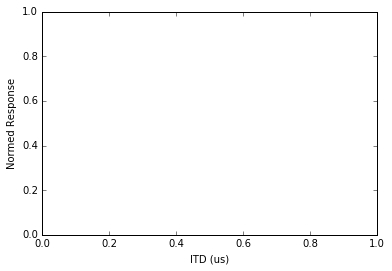

In [286]:
D_STEP = 10
graph_neurons(out[:10], D_STEP)

[ 0.26978778  0.33564913  0.38090071  0.46348828  0.5377692   0.60655033
  0.63472578  0.69962546  0.77766095  0.80233753  0.78584851  0.76155301
  0.74598547  0.70252176  0.67178228  0.59946871  0.55147317  0.50321149
  0.44268819  0.39735729  0.32778043]


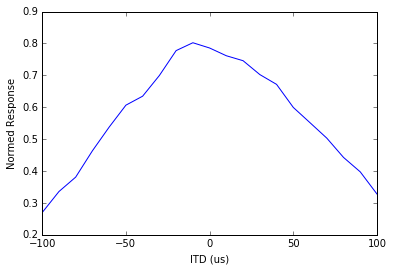

In [279]:
graph_mean(mean_out, D_STEP)
print(mean_out)
# These would be the mean values for 10 neurons before
# the learning process happens

In [161]:
# Do same data processing for the learning curves after 
# the learning happens

out_3, maxes3 = align_cut2(n, DIST, len(vals_testing), maxes)
out3 = np.array(list(out_3.values()))
#print out3.shape
#print [len(x) for x in out3]
print(out3.shape)
mean_out3 = filtered_mean(out3)
print(mean_out3.shape)

(60, 21)
(21,)


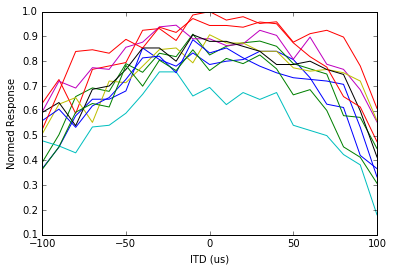

In [163]:
graph_neurons(out3[:10], D_STEP)

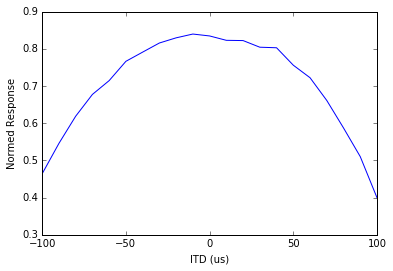

In [164]:
graph_mean(mean_out3, D_STEP)

In [169]:
for i in [10]:

    activity = y[:, i]
    dt = 0.001

    test1_activity = activity[int(childhood/dt):int(training1/dt)]
    test2_activity = activity[int(glasses_on/dt):int(training2/dt)]

    mean1_activity = np.mean(test1_activity.reshape(train_int, (time_per_val_testing/dt)),axis=1)
    mean2_activity = np.mean(test2_activity.reshape(train_int, (time_per_val_testing/dt)),axis=1)
    
    
    indices1 = np.where(mean1_activity==mean1_activity.max())
    indices2 = np.where(mean2_activity==mean2_activity.max())
    increment = int(indices1[0][0])
    increment2 = int(indices2[0][0])
    #print(increment, increment2)
    
    for j in range(len(mean1_activity)-1):
        rightmost = np.asarray(np.where(mean1_activity>0))
        r1 = rightmost[-1][-1]
        
    a = np.asarray(np.where(mean1_activity >= 0))
    indicies_to_adjust1 = np.where(mean1_activity >= r1)
    indicies_to_adjust1 = np.asarray(indicies_to_adjust1)
    indicies_to_adjust1[:] = [(x-increment) for x in indicies_to_adjust1]
    ##################
    
    
    x = (indicies_to_adjust1[-1][-1]) + 1
    tobeadded = a.shape[1]- indicies_to_adjust1.shape[1]
    print(a.shape[1], indicies_to_adjust1.shape[1], tobeadded)
    extra_numbers = []
    for j in range(tobeadded):
        extra_numbers.append(x)
        x += 1

    extra_numbers = np.asarray(extra_numbers)
    indicies_simplified1 = indicies_to_adjust1[0]
    k = np.hstack((indicies_simplified1,extra_numbers))
    print(k)
  
   
    adj = indicies_to_adjust2.shape[1] 
    print(adj)


    k = np.asarray(k.reshape(k.shape[0],1))
    k2 = k
    
    k2[:] = [(x-adj)for x in k2]

    
    pylab.plot(k, mean1_activity, c='g')
    pylab.plot(k, mean2_activity, c='b')
    plt.xlabel('ITD relative to best')
    

/home/stacy/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/stacy/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


IndexError: index -1 is out of bounds for axis 0 with size 0

In [292]:
k = 5
mean1_array = []
mean2_array = []
for i in range(k):
    activity = y[:,i]
    dt = 0.001

    test1_activity = activity[int(childhood/dt):int(training1/dt)]
    test2_activity = activity[int(glasses_on/dt):int(training2/dt)]

    mean1_activity = np.mean(test1_activity.reshape(train_int, (time_per_val_testing/dt)),axis=1)
    mean2_activity = np.mean(test2_activity.reshape(train_int, (time_per_val_testing/dt)),axis=1)
    
    mean1_array.append(mean1_activity)
    mean2_array.append(mean2_activity)
    
    max_mean1 = mean1_activity.max()
    max_mean2 = mean2_activity.max()
    #print(max_mean1, max_mean2)
    indices1 = np.where(mean1_activity==mean1_activity.max())
    indices2 = np.where(mean2_activity==mean2_activity.max())
    increment = int(indices1[0][0])
    increment2 = int(indices2[0][0])
    #print(increment, increment2)

    indicies_to_adjust1 = np.where(mean1_activity >= 0)
    indicies_to_adjust1 = np.asarray(indicies_to_adjust1)
    indicies_to_adjust1[:] = [(x-increment) for x in indicies_to_adjust1]
    #print(indicies_to_adjust1)

    indicies_to_adjust2 = np.where(mean2_activity >= 0)
    indicies_to_adjust2 = np.asarray(indicies_to_adjust2)
    indicies_to_adjust2[:] = [(x-increment) for x in indicies_to_adjust2]
    #print(indicies_to_adjust2[0])
    #mean1_activity[:] = [(x-increment) for x in mean1_activity]

    indicies_to_adjust1 = indicies_to_adjust1[0].reshape(train_int,1)
    indicies_to_adjust2 = indicies_to_adjust2[0].reshape(train_int,1)
    #pylab.plot(indicies_to_adjust1, mean1_activity, c='g')
    #pylab.plot(indicies_to_adjust2, mean2_activity, c='b')


type(mean1_array)
n, rate_peaks = calc_norm(mean1_array)
out_, maxes = align_cut2(n, DIST, len(vals_testing))
#print(out_)

out = np.array(list(out_.values()))
#mean_out = np.mean(out, axis=0)
mean_out = filtered_mean(out)

/home/stacy/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/stacy/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


TypeError: list indices must be integers or slices, not tuple

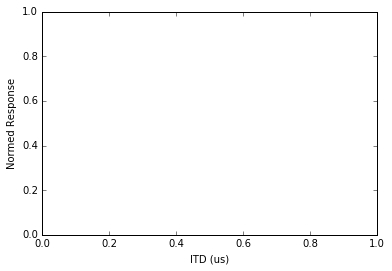

In [281]:
D_STEP = 10
graph_neurons(out[:10], D_STEP)